In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Load Data


In [2]:
champs = pd.read_csv("data_champs_elysee.csv", delimiter=";")
convention = pd.read_csv("data_convention.csv", delimiter=";")
st_peres = pd.read_csv("data_saints_peres.csv", delimiter=";")
print("len(champs):", len(champs))
print("len(convention):", len(convention))
print("len(st_peres):", len(st_peres))

len(champs): 9362
len(convention): 187000
len(st_peres): 37448


Let's filter data based on the entrance and exit nodes :

- **Champs-Elysées** : Noeud amont “Av_Champs_Elysees-Washington” et noeud aval “Av_Champs_Elysees-Berri”
- **Convention** : Noeud amont “Convention-Blomet” et noeud aval “Lecourbe-Convention”
- **Saints-Pères** : Noeud amont “Sts_Peres-Voltaire” et noeud aval “Sts_Peres-Universite”


In [3]:
champs = champs.loc[
    (champs["Libelle noeud amont"] == "Av_Champs_Elysees-Washington")
    & (champs["Libelle noeud aval"] == "Av_Champs_Elysees-Berri")
]

convention = convention.loc[
    (convention["Libelle noeud amont"] == "Convention-Blomet")
    & (convention["Libelle noeud aval"] == "Lecourbe-Convention")
]

st_peres = st_peres.loc[
    (st_peres["Libelle noeud amont"] == "Sts_Peres-Voltaire")
    & (st_peres["Libelle noeud aval"] == "Sts_Peres-Universite")
]

print("len(champs):", len(champs))
print("len(convention):", len(convention))
print("len(st_peres):", len(st_peres))

len(champs): 9362
len(convention): 9350
len(st_peres): 9362


## Process Data


Checking missing values :


In [4]:
print("champs.isnull().sum():", champs.isnull().sum())
print("convention.isnull().sum():", convention.isnull().sum())
print("st_peres.isnull().sum():", st_peres.isnull().sum())

champs.isnull().sum(): Identifiant arc                0
Libelle                        0
Date et heure de comptage      0
Débit horaire                267
Taux d'occupation            288
Etat trafic                    0
Identifiant noeud amont        0
Libelle noeud amont            0
Identifiant noeud aval         0
Libelle noeud aval             0
Etat arc                       0
Date debut dispo data          0
Date fin dispo data            0
geo_point_2d                   0
geo_shape                      0
dtype: int64
convention.isnull().sum(): Identifiant arc               0
Libelle                       0
Date et heure de comptage     0
Débit horaire                38
Taux d'occupation            35
Etat trafic                   0
Identifiant noeud amont       0
Libelle noeud amont           0
Identifiant noeud aval        0
Libelle noeud aval            0
Etat arc                      0
Date debut dispo data         0
Date fin dispo data           0
geo_point_2d              

We have ≈ 300 then 50 and 120 missing values for Champs-Elysées, Convention and Saints-Pères respectively. This is way less than the number of rows in the dataset, but let's see if these missing values are spread out or not. They could be related to a particular event.


In [5]:
champs["Date et heure de comptage"] = pd.to_datetime(
    champs["Date et heure de comptage"], utc=True
)
convention["Date et heure de comptage"] = pd.to_datetime(
    convention["Date et heure de comptage"], utc=True
)
st_peres["Date et heure de comptage"] = pd.to_datetime(
    st_peres["Date et heure de comptage"], utc=True
)

In [6]:
# Removing the UTC timezone from the datetime
champs["Date et heure de comptage"] = champs[
    "Date et heure de comptage"
].dt.tz_localize(None)

convention["Date et heure de comptage"] = convention[
    "Date et heure de comptage"
].dt.tz_localize(None)

st_peres["Date et heure de comptage"] = st_peres[
    "Date et heure de comptage"
].dt.tz_localize(None)

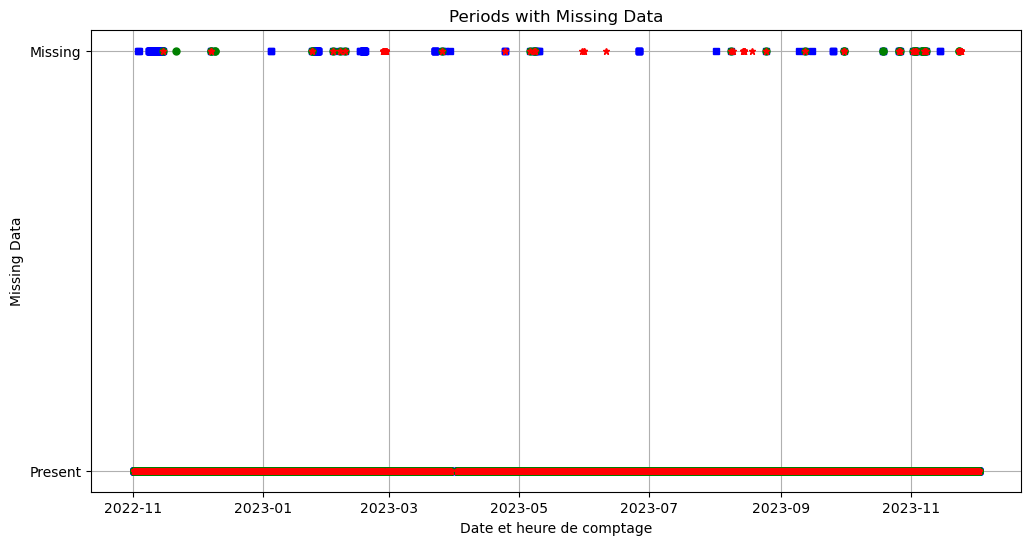

In [7]:
# Create a boolean mask where missing values are True
champs_missing = champs["Débit horaire"].isnull()
convention_missing = convention["Débit horaire"].isnull()
st_peres_missing = st_peres["Débit horaire"].isnull()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(
    champs["Date et heure de comptage"],
    champs_missing,
    marker="s",
    linestyle="None",
    markersize=5,
    color="blue",
)
plt.plot(
    convention["Date et heure de comptage"],
    convention_missing,
    marker="o",
    linestyle="None",
    markersize=5,
    color="green",
)
plt.plot(
    st_peres["Date et heure de comptage"],
    st_peres_missing,
    marker="*",
    linestyle="None",
    markersize=5,
    color="red",
)
plt.grid(True)
plt.title("Periods with Missing Data")
plt.xlabel("Date et heure de comptage")
plt.ylabel("Missing Data")
plt.yticks([0, 1], ["Present", "Missing"])
plt.show()

They are spread out, so we can't just drop them.


In [8]:
champs = champs.dropna()
convention = convention.dropna()
st_peres = st_peres.dropna()

Let's have an overview of the data now :


In [10]:
etat_trafic = {"Fluide": 1, "Pré-saturé": 2, "Saturé": 3, "Bloqué": 4, "Inconnu": 0}
etat_arc = {"Ouvert": 1, "Barré": 2, "Invalide": 3, "Inconnu": 0}

In [14]:
def plot_trafic_list(db_list, titles):
    fig, axes = plt.subplots(1, len(db_list), figsize=(20, len(db_list)))
    for i, db in enumerate(db_list):
        # Calculate the percentage of each "Etat trafic"
        etat_trafic_count = db["Etat trafic"].value_counts()
        etat_trafic_percent = etat_trafic_count / etat_trafic_count.sum()
        print("\n---- " + titles[i] + " ----")
        print(etat_trafic_percent)

        axes[i].scatter(
            db["Date et heure de comptage"],
            db["Débit horaire"],
            c=db["Etat trafic"].map(etat_trafic),
            s=10,
            cmap="magma",
        )
        axes[i].set_title(titles[i])
        axes[i].set_xlabel("Date et heure de comptage")
        axes[i].set_ylabel("Débit horaire")
        # reduce the font size of the x-axis tick labels
        axes[i].tick_params(axis="x", which="major", labelsize=8, rotation=45)
        axes[i].grid(True)
    plt.show()


---- Champs Elysee ----
Pré-saturé    0.471236
Fluide        0.409742
Saturé        0.084307
Bloqué        0.034715
Name: Etat trafic, dtype: float64

---- Convention ----
Fluide        0.998067
Pré-saturé    0.001933
Name: Etat trafic, dtype: float64

---- Saints Peres ----
Fluide        0.965417
Pré-saturé    0.032746
Saturé        0.001837
Name: Etat trafic, dtype: float64


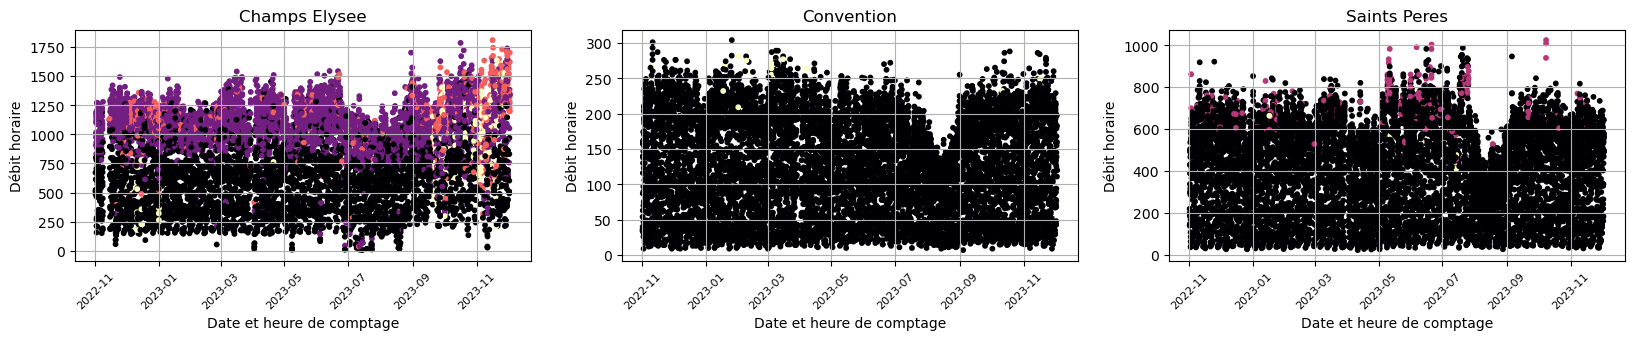

In [15]:
db_list = [champs, convention, st_peres]
titles = ["Champs Elysee", "Convention", "Saints Peres"]
plot_trafic_list(db_list, titles)

Our focus is to forecast for the dates from 08/12 to 12/12. Therefore, let's have a more precise look at the data in december for each year :



---- Champs Elysee ----
Fluide        0.414986
Pré-saturé    0.350144
Saturé        0.197406
Bloqué        0.037464
Name: Etat trafic, dtype: float64

---- Convention ----
Fluide    1.0
Name: Etat trafic, dtype: float64

---- Saints Peres ----
Fluide        0.982684
Pré-saturé    0.017316
Name: Etat trafic, dtype: float64


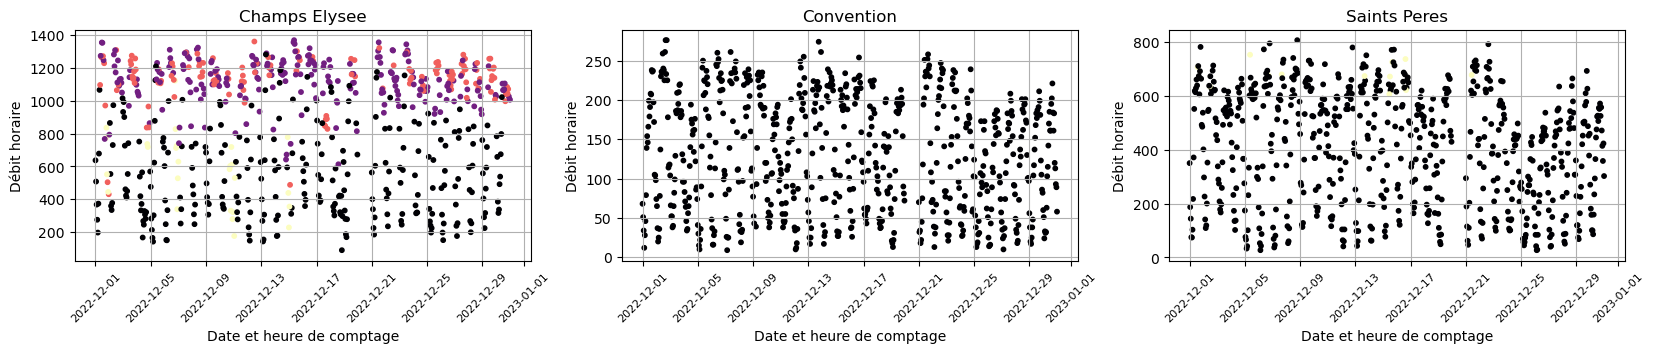

In [16]:
# Create the start date of december in format datetime64[ns, UTC]
dec_start = pd.to_datetime("2022-12-01")
dec_end = pd.to_datetime("2022-12-31")

champs_december = champs.loc[
    (champs["Date et heure de comptage"] >= dec_start)
    & (champs["Date et heure de comptage"] <= dec_end)
]

convention_december = convention.loc[
    (convention["Date et heure de comptage"] >= dec_start)
    & (convention["Date et heure de comptage"] <= dec_end)
]

st_peres_december = st_peres.loc[
    (st_peres["Date et heure de comptage"] >= dec_start)
    & (st_peres["Date et heure de comptage"] <= dec_end)
]

db_list_december = [champs_december, convention_december, st_peres_december]

plot_trafic_list(db_list_december, titles)